In [34]:
import torch
import torchvision
import torch.nn as nn
import abc
from torchvision import transforms
import logging
import os
import skimage
from PIL import Image
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from scipy import stats
import numpy as np
import pandas as pd

In [181]:
## Process car_damage data

# Size 64 variables
# size = (64, 64) # disentangling-vae project only handles square images of size 64 and 32
# trans_root = "data/car_damage_64"

# Size 128 variables
size = (128, 128)
trans_root = "data/car_damage_128"

# Other variables
im_format = "JPEG"
orig_root = "data/car_damage_orig"

if not os.path.isdir(trans_root):
    os.mkdir(trans_root)
    
for im_label in ("Real/",):#, "Fake/Galaxy Note", "Fake/Ipad"):
    if not os.path.isdir(os.path.split(im_label)[0]):
        os.mkdir(os.path.join(trans_root, os.path.split(im_label)[0]))
    print("Processing {} images".format(im_label))
    for im_name in tqdm(os.listdir('/'.join((orig_root, im_label)))):
        orig_im_path = os.path.join(orig_root, im_label, im_name)
        im = Image.open(orig_im_path)
        im = im.resize(size, Image.ANTIALIAS)
        trans_im_path = os.path.join(trans_root, os.path.split(im_label)[0], im_name)
        im.save(trans_im_path, im_format)

  2%|▏         | 23/1047 [00:00<00:04, 222.48it/s]

Processing Real/ images


100%|██████████| 1047/1047 [00:03<00:00, 317.56it/s]


In [182]:
# Get car_damage dataset stats
root = "data/car_damage_128"
imgs = []
for img_label in "Real", "Fake":
    label_dir = os.path.join(root, img_label)
    for name in os.listdir(label_dir):
        full_name = os.path.join(root, img_label, name)
        if os.path.isdir(full_name):
            imgs.extend(glob.glob(os.path.join(full_name, '*')))
        else:
            imgs.append(full_name)
            
img_sizes = np.asarray(list(map(lambda img: Image.open(img).size, imgs))).transpose()

In [186]:
# Inspect car_damage dataset stats
# print(img_sizes.shape)
h, w = img_sizes

real_h, fake_h, real_w, fake_w = h[:1047], h[1047:], w[:1047], w[1047:]
for func in np.mean, np.min, np.max:
    print("function, real_h, fake_h, real_w, fake_w")
    print(func.__name__, tuple(map(np.mean, (real_h, fake_h, real_w, fake_w))))
    print()

function, real_h, fake_h, real_w, fake_w
mean (128.0, 128.0, 128.0, 128.0)

function, real_h, fake_h, real_w, fake_w
amin (128.0, 128.0, 128.0, 128.0)

function, real_h, fake_h, real_w, fake_w
amax (128.0, 128.0, 128.0, 128.0)



In [11]:
# class Example(abc.ABC):
#     def __init__(self):
#         print("Hello World")
#         return
    
# #     @abc.abstractmethod
#     def test(self):
#         print("abstract test")
#         return
    
# class SubExample(Example, abc.ABC):
#     def __init__(self):
#         super().__init__()
#         print('this')
        
    
#     def test(self):
#         super().test()
#         print("subtest")
#         return
    
# se = SubExample()

# # se.__class__.__mro__


Hello World
this


In [33]:
# Inspect Training losses for a model
model_name = "btcvae_celeba_mini"
train_loss_path = os.path.join("results",model_name,"train_losses.log")
loss_df = pd.read_csv(train_loss_path)
loss_df.info()
p_df = loss_df.pivot(index="Epoch", columns="Loss", values="Value")
display(p_df)
p_df.sum().to_frame().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Epoch   80 non-null     int64  
 1   Loss    80 non-null     object 
 2   Value   80 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.0+ KB


Loss,dw_kl_loss,kl_loss,kl_loss_0,kl_loss_1,kl_loss_2,kl_loss_3,kl_loss_4,kl_loss_5,kl_loss_6,kl_loss_7,kl_loss_8,kl_loss_9,loss,mi_loss,recon_loss,tc_loss
Epoch,,,,,,,,,,,,,,,,
0,5.135144,19.764903,1.433209,1.569566,1.673959,2.484999,2.064408,1.147333,1.906047,1.251666,4.965048,1.268667,6783.584106,55.163676,6971.484711,-40.541056
1,3.379485,20.944487,1.746876,1.746193,1.950997,2.630318,1.797346,1.555877,2.085359,1.553883,4.284150,1.593490,6493.865112,55.647522,6666.600159,-38.128572
2,2.716414,20.415305,1.779124,1.787345,1.952323,2.473484,1.797363,1.579483,2.041079,1.580075,3.829912,1.595116,6475.108124,55.636738,6646.543549,-37.934269
3,2.211204,20.363970,1.823140,1.803970,1.973203,2.454450,1.806602,1.576860,2.113552,1.602026,3.589653,1.620515,6451.565948,55.609610,6620.016205,-37.445338
4,1.896586,20.013828,1.782661,1.795327,1.965347,2.407565,1.815303,1.541823,2.087779,1.574010,3.457904,1.586110,6443.735016,55.628182,6612.737488,-37.550918


Loss,dw_kl_loss,kl_loss,kl_loss_0,kl_loss_1,kl_loss_2,kl_loss_3,kl_loss_4,kl_loss_5,kl_loss_6,kl_loss_7,kl_loss_8,kl_loss_9,loss,mi_loss,recon_loss,tc_loss
0,15.338833,101.502492,8.565009,8.702401,9.515829,12.450816,9.281022,7.401375,10.233816,7.56166,20.126667,7.663898,32647.858307,277.685729,33517.382111,-191.600152


,Epoch,Loss,Value
0,0,recon_loss,6971.484711
16,1,recon_loss,6666.600159
32,2,recon_loss,6646.543549
48,3,recon_loss,6620.016205
64,4,recon_loss,6612.737488


<AxesSubplot:>

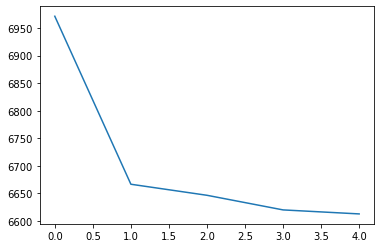